In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras


In [2]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"
train_data = pd.read_csv(TRAIN_DATA_URL)
test_data = pd.read_csv(TEST_DATA_URL)

In [4]:
train_data = train_data[100:]
valid_data = train_data[:100]

In [ ]:
test_data.head()

In [29]:
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(527, 9)
(264, 9)
(100, 9)


In [6]:
train_data.describe()

,survived,age,n_siblings_spouses,parch,fare
count,527.000000,527.000000,527.000000,527.000000,527.000000
mean,0.394687,29.885199,0.529412,0.377609,34.907889
std,0.489248,12.398154,1.169393,0.765034,55.983347
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.500000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.245800
75%,1.000000,36.000000,1.000000,0.000000,31.331250
max,1.000000,80.000000,8.000000,5.000000,512.329200


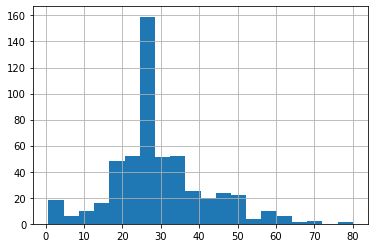

In [7]:
train_data.age.hist(bins =20)
plt.show()

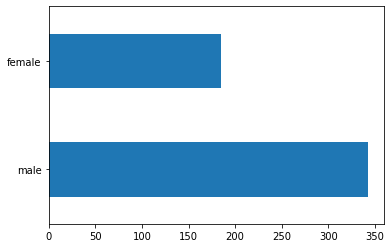

In [8]:
train_data.sex.value_counts().plot(kind = 'barh')
plt.show()

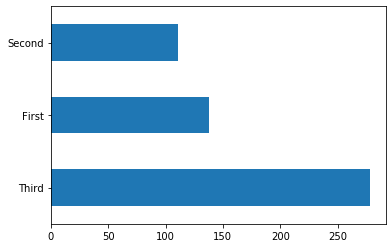

In [9]:
train_data['class'].value_counts().plot(kind = 'barh')
plt.show()

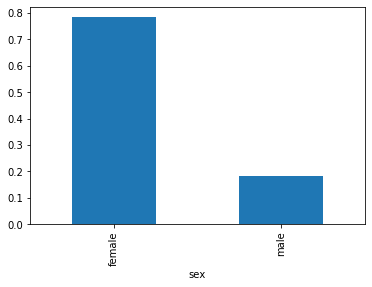

In [10]:
train_data.groupby('sex').survived.mean().plot(kind='bar')

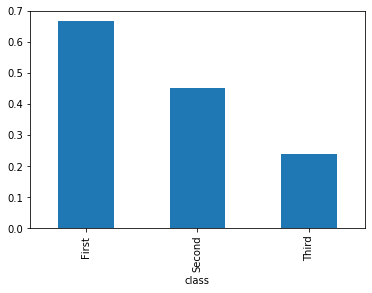

In [11]:
train_data.groupby('class').survived.mean().plot(kind='bar')

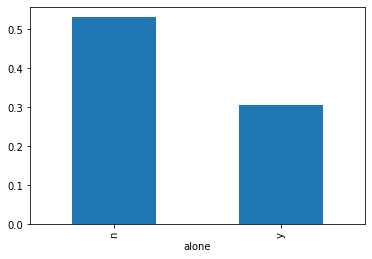

In [12]:
train_data.groupby('alone').survived.mean().plot(kind='bar')

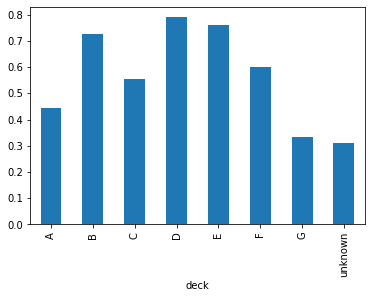

In [13]:
train_data.groupby('deck').survived.mean().plot(kind='bar')

In [14]:
train_data[train_data.isnull()].count()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [15]:
y_train= train_data.pop('survived')
y_test = test_data.pop('survived')
y_valid = valid_data.pop('survived')


In [ ]:
train_data.head()

In [17]:
categorical_columns =['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
numeric_columns=['age','fare']
feature_columns = []
#处理离散值特征
for categorical_column in categorical_columns:
    vocab = train_data[categorical_column].unique()
    print(categorical_column,': ',vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
                    tf.feature_column.categorical_column_with_vocabulary_list(
                                                                              categorical_column, vocab)))
# tf.feature_column.indicator_column,对离散数据进行one_hot编码

#处理连续型特征
for numeric_column in numeric_columns:
    feature_columns.append(
          tf.feature_column.numeric_column(
                      numeric_column, dtype=tf.float32))

sex :  ['male' 'female']
n_siblings_spouses :  [0 1 2 8 4 3 5]
parch :  [0 2 1 4 3 5]
class :  ['Third' 'Second' 'First']
deck :  ['unknown' 'D' 'C' 'B' 'E' 'F' 'G' 'A']
embark_town :  ['Southampton' 'Cherbourg' 'Queenstown']
alone :  ['y' 'n']


In [18]:
feature_columns[1]

IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(0, 1, 2, 8, 4, 3, 5), dtype=tf.int64, default_value=-1, num_oov_buckets=0))

In [40]:
#构建datasets
def make_dataset(x,y,epochs=10,shuffle=True,batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(x), y))#from_tensor_slices要传入字典
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset
    

In [26]:
train_dataset = make_dataset(train_data, y_train)
test_dataset = make_dataset(test_data,y_test,shuffle = False)
valid_dataset = make_dataset(valid_data,y_valid,shuffle = False)

In [21]:
for x,y in train_dataset.take(1):
    print(x, '\n\n', y, '\n\n',x['age'])


{'sex': <tf.Tensor: id=82, shape=(32,), dtype=string, numpy=
array([b'male', b'male', b'male', b'male', b'female', b'male', b'female',
       b'male', b'male', b'male', b'male', b'male', b'male', b'female',
       b'female', b'female', b'female', b'female', b'female', b'female',
       b'male', b'male', b'male', b'male', b'female', b'female', b'male',
       b'female', b'male', b'female', b'female', b'female'], dtype=object)>, 'age': <tf.Tensor: id=74, shape=(32,), dtype=float32, numpy=
array([16., 28., 60., 65., 17., 28., 35., 28., 36., 28., 16., 29., 44.,
       47., 40.,  4., 28., 50., 31., 47., 28., 37., 28., 34., 28., 28.,
       23., 54., 28., 28., 38., 45.], dtype=float32)>, 'n_siblings_spouses': <tf.Tensor: id=80, shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)>, 'parch': <tf.Tensor: id=81, shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [22]:
#实验
# keras.layers.DenseFeatures可以将Feature定义的规则运用到dataset的每一个数据上

for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())#将age_column的规则运用到x上在打印numpy值
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())
#出现warning是提示float64自动转为float32，tensorflow2可以忽略

[[36.]
 [25.]
 [28.]
 [45.]
 [28.]
 [28.]
 [23.]
 [24.]
 [57.]
 [ 6.]
 [35.]
 [ 2.]
 [21.]
 [24.]
 [24.]
 [23.]
 [53.]
 [33.]
 [31.]
 [60.]
 [64.]
 [34.]
 [28.]
 [33.]
 [28.]
 [28.]
 [23.]
 [ 1.]
 [20.]
 [34.]
 [22.]
 [28.]]
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [23]:
#实验
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())#将feature_columns的规则运用到x上在打印numpy值


[[28.  0.  1. ...  0.  0.  1.]
 [21.  1.  0. ...  0.  0.  1.]
 [57.  1.  0. ...  0.  0.  1.]
 ...
 [28.  0.  1. ...  0.  0.  1.]
 [28.  1.  0. ...  0.  1.  0.]
 [56.  1.  0. ...  0.  1.  0.]]


In [24]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',
                     optimizer = keras.optimizers.SGD(lr=0.01),
                     metrics = ['accuracy'])



In [30]:
# 1.model.fit
# 2.model -> estimator ->train
train_dataset = make_dataset(train_data, y_train,epochs=100)
test_dataset = make_dataset(test_data, y_test,epochs=1,shuffle=False)
history = model.fit(train_dataset,steps_per_epoch=527//32,epochs=100,validation_data = valid_dataset,validation_steps=3)#steps_per_epoch=训练集的样本数//batch_size

Train for 16 steps, validate for 3 steps
Epoch 1/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4695 - accuracy: 0.7754 - val_loss: 0.4512 - val_accuracy: 0.7708
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 0.4645 - accuracy: 0.8086 - val_loss: 0.4350 - val_accuracy: 0.8021
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4845 - accuracy: 0.7715 - val_loss: 0.4377 - val_accuracy: 0.8125
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4781 - accuracy: 0.7812 - val_loss: 0.4335 - val_accuracy: 0.8229
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.5101 - accuracy: 0.7734 - val_loss: 0.4567 - val_accuracy: 0.7604
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4806 - accuracy: 0.7793 - val_loss: 0.4324 - val_accuracy: 0.8125
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4479 - accuracy: 0.8105 - val_l

16/16 [==============================] - 0s 14ms/step - loss: 0.4682 - accuracy: 0.7988 - val_loss: 0.4456 - val_accuracy: 0.8021
Epoch 59/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4757 - accuracy: 0.7832 - val_loss: 0.5051 - val_accuracy: 0.7188
Epoch 60/100
16/16 [==============================] - 0s 15ms/step - loss: 0.4678 - accuracy: 0.7969 - val_loss: 0.4417 - val_accuracy: 0.7917
Epoch 61/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4782 - accuracy: 0.7930 - val_loss: 0.4200 - val_accuracy: 0.8229
Epoch 62/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4527 - accuracy: 0.7773 - val_loss: 0.5198 - val_accuracy: 0.7604
Epoch 63/100
16/16 [==============================] - 0s 15ms/step - loss: 0.4455 - accuracy: 0.8008 - val_loss: 0.4149 - val_accuracy: 0.8333
Epoch 64/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4221 - accuracy: 0.8184 - val_loss: 0.4441 - val_accuracy: 0.7917
Epoch 65/100

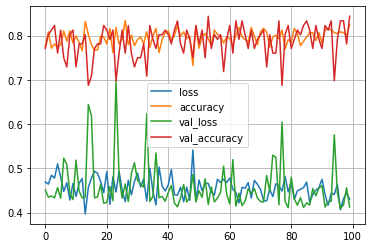

In [31]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

In [41]:
# 2.model -> estimator ->train
estimator = keras.estimator.model_to_estimator(model)
estimator.train(input_fn=lambda: make_dataset(train_data, y_train,epochs=100))
#input_fn：1、参数是一个函数
#            2、返回元组（features,labels）或（feature,label)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/l7/d1pnsddn4wd3z6qry0tp5rvh0000gn/T/tmp0h6id7rp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x6461f5890>, '_task_type': 'worker', '_task_id': 0, '_glo

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.

In [35]:
import tempfile
model_dir = tempfile.mkdtemp()
keras_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model, model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/l7/d1pnsddn4wd3z6qry0tp5rvh0000gn/T/tmp1be0izul', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x6460e8750>, '_task_type': 'worker', '_task_id': 0, '_glo